# "Detecção de pneumonia em radiografias com CNN's"

A pneumonia é uma infecção pulmonar que pode ser causada por bactérias, vírus ou fungos, afetando especialmente pessoas com o sistema imunológico comprometido, idosos e crianças pequenas. Ela ocorre quando esses agentes infecciosos causam inflamação nos alvéolos, as pequenas bolsas de ar nos pulmões, que podem se encher de líquido ou pus, dificultando a troca adequada de oxigênio no organismo. Essa condição, quando não diagnosticada e tratada precocemente, pode evoluir para quadros graves e até mesmo ser fatal. A detecção precoce da pneumonia é fundamental para a escolha de um tratamento adequado, aumentando as chances de recuperação e reduzindo as complicações. Além disso, o diagnóstico antecipado contribui para reduzir o tempo de hospitalização e o impacto sobre os sistemas de saúde, especialmente em períodos de epidemias e em grupos vulneráveis. Para contribuir com esse diagnóstico, neste projeto desenvolvi um modelo de deep learning com redes neurais convolucionais (CNNs) utilizando a biblioteca PyTorch. O uso desse sistema pode reduzir o tempo de diagnóstico, padronizar o processo e ajudar na identificação precoce, permitindo intervenções rápidas e precisas, o que é especialmente crucial em áreas com poucos recursos médicos.

**Fonte dos dados:** https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Obtendo e conhecendo os dados

In [91]:
!pip install torchmetrics

In [92]:
# Importando as bibliotecas necessárias

import os  # Para realizar operações no sistema de arquivos, como criação de diretórios e navegação
import kagglehub  # Para baixar datasets diretamente do Kaggle para o ambiente de trabalho
import zipfile  # Para descompactar arquivos .zip que contêm os dados do projeto
import random  # Para embaralhar listas de arquivos, auxiliando na divisão de dados em treino e teste
import shutil  # Para copiar e mover arquivos entre diretórios, útil na organização dos dados

# Bibliotecas para visualização e manipulação de dados
import matplotlib.pyplot as plt  # Para visualizar gráficos e imagens das radiografias
import numpy as np  # Para manipulação de arrays, facilitando operações numéricas

# Bibliotecas principais para construção e treinamento do modelo
import torch  # Para trabalhar com tensores e realizar computação acelerada por GPU
from torchvision import datasets, transforms  # Para manipular datasets de imagens e aplicar transformações (ex.: redimensionamento, normalização)
from torch.utils.data import DataLoader  # Para carregar dados em mini-batches, facilitando o treinamento do modelo
from torch import nn  # Para construção de redes neurais e definição de camadas
from torch import optim  # Para algoritmos de otimização, como o SGD e Adam

# Bibliotecas para avaliação e métricas de performance
import torchmetrics  # Para calcular métricas de performance de maneira simples e eficiente
from torchmetrics import Accuracy  # Para calcular a acurácia do modelo durante o treinamento

# Utilitários para monitoramento e visualização do progresso do treinamento
from timeit import default_timer as timer  # Para medir o tempo de execução do treinamento e avaliação do modelo
from tqdm.auto import tqdm  # Para exibir barras de progresso em loops longos, como o treinamento por épocas

# Importando métricas adicionais para avaliação de performance
from torchmetrics import ConfusionMatrix  # Para calcular a matriz de confusão, útil na avaliação de classificadores

# Ferramentas para visualização da matriz de confusão
import mlxtend  # Biblioteca com diversas funcionalidades de machine learning, incluindo visualização de métricas
from mlxtend.plotting import plot_confusion_matrix  # Para plotar a matriz de confusão com mais detalhes

# Utilitário para gerenciar caminhos de arquivos
from pathlib import Path  # Para manipulação de caminhos de arquivos, facilitando operações em diferentes sistemas operacionais


In [93]:
# Baixa a última versão do dataset de pneumonia por meio do KaggleHub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Baixa o dataset de pneumonia do Kaggle usando o comando de terminal
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Descompacta o arquivo baixado na pasta `chest-xray-pneumonia`
with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
    zip_ref.extractall("chest-xray-pneumonia")

# Define o caminho do dataset original e o novo caminho para o dataset reestruturado
dataset_path = '/content/chest-xray-pneumonia/chest_xray'  # Caminho original dos dados
new_dataset_path = '/content/chest-xray-pneumonia/new_chest_xray'  # Caminho onde o novo dataset será armazenado

# Cria a nova estrutura de diretórios, caso não exista
if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

    # Para cada classe (NORMAL e PNEUMONIA), carrega os arquivos e os distribui em conjuntos de treino, validação e teste
    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f'{dataset_path}/{split}/{cls}'  # Define a pasta fonte
            files = os.listdir(source_folder)  # Lista os arquivos na pasta fonte
            all_files.extend([(file, source_folder) for file in files])  # Adiciona todos os arquivos à lista

        # Embaralha todos os arquivos da classe atual
        random.seed(42)
        random.shuffle(all_files)

        # Divide os arquivos em 80% para treino, 10% para validação e 10% para teste
        train_files = all_files[:int(len(all_files) * 0.8)]
        val_files = all_files[int(len(all_files) * 0.8):int(len(all_files) * 0.9)]
        test_files = all_files[int(len(all_files) * 0.9):]

        # Copia os arquivos de treino para a nova estrutura de pastas
        for file, source_folder in train_files:
            dest = f'{new_dataset_path}/train/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        # Copia os arquivos de validação para a nova estrutura de pastas
        for file, source_folder in val_files:
            dest = f'{new_dataset_path}/val/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        # Copia os arquivos de teste para a nova estrutura de pastas
        for file, source_folder in test_files:
            dest = f'{new_dataset_path}/test/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


A diferença da base de dados que estou utilizando para original do Kaggle é apenas um rearranjo que fiz pois na base original temos apenas 16 imagens no conjunto de validação. Como julgo serem poucos dados refiz as bases de dados fazendo um split 80-10-10.

In [94]:
# Define o caminho para o conjunto de dados de treino, teste e validação, onde as imagens de treino estão armazenadas
train_data_path = '/content/chest-xray-pneumonia/new_chest_xray/train'
test_data_path = '/content/chest-xray-pneumonia/new_chest_xray/test'
validation_data_path = '/content/chest-xray-pneumonia/new_chest_xray/val'

# Transformações para as imagens do dataset
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # Redimensionando a imagem
    transforms.RandomHorizontalFlip(p=0.5), # Flipando a imagem horizontalmente
    transforms.RandomInvert(p = 0.5), # Invertendo a imagem
    transforms.ToTensor(),  # Transformando a imagem em tensor
])

# Carrega o conjunto de dados de treino usando ImageFolder, que organiza as imagens em subpastas por classes
# Aplica a transformação ToTensor() para converter as imagens em tensores PyTorch, necessário para treinamento
train_data = datasets.ImageFolder(root=train_data_path, transform = data_transform)
test_data = datasets.ImageFolder(root=test_data_path, transform = data_transform)
validation_data = datasets.ImageFolder(root=validation_data_path, transform = data_transform)

# Exibe o número de amostras em cada conjunto (treino, teste e validação)
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Number of validation samples: {len(validation_data)}")


Number of training samples: 4684
Number of test samples: 587
Number of validation samples: 585


In [95]:
# Verificando o shape de uma imagem da base de dados de treino
image, label = train_data[0]
image.shape, label

(torch.Size([3, 224, 224]), 0)

Importante pontuar que erros de shape são bastante comuns em PyTorch, aqui temos uma formatação do tipo [Color channels, Height, Width] mas bibliotecas como matplotlib aceitam apenas a formatação [Height, Width, Color channels]. Por isso em alguns momentos desse projeto usarei o `torch.permute`.

In [96]:
# Verificando os labels
class_names = train_data.classes
class_dict = train_data.class_to_idx
print(class_dict)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [97]:
from collections import Counter

# Contando as classes no conjunto de dados de treino
train_labels = [label for _, label in train_data]  # Extraímos os rótulos das imagens
train_class_counts = Counter(train_labels)  # Conta a quantidade de imagens por classe no conjunto de treino

# Exibe a quantidade de imagens por classe no conjunto de treino
print("Quantidade de imagens por classe no conjunto de treino:")
for class_idx, count in train_class_counts.items():
    class_name = train_data.classes[class_idx]  # Obtém o nome da classe a partir do índice
    print(f"Classe '{class_name}': {count} imagens")

# Contando as classes no conjunto de dados de teste
test_labels = [label for _, label in test_data]
test_class_counts = Counter(test_labels)

print("\nQuantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_counts.items():
    class_name = test_data.classes[class_idx]
    print(f"Classe '{class_name}': {count} imagens")

# Contando as classes no conjunto de dados de validação
validation_labels = [label for _, label in validation_data]
validation_class_counts = Counter(validation_labels)

print("\nQuantidade de imagens por classe no conjunto de validação:")
for class_idx, count in validation_class_counts.items():
    class_name = validation_data.classes[class_idx]
    print(f"Classe '{class_name}': {count} imagens")


Quantidade de imagens por classe no conjunto de treino:
Classe 'NORMAL': 1266 imagens
Classe 'PNEUMONIA': 3418 imagens

Quantidade de imagens por classe no conjunto de teste:
Classe 'NORMAL': 159 imagens
Classe 'PNEUMONIA': 428 imagens

Quantidade de imagens por classe no conjunto de validação:
Classe 'NORMAL': 158 imagens
Classe 'PNEUMONIA': 427 imagens


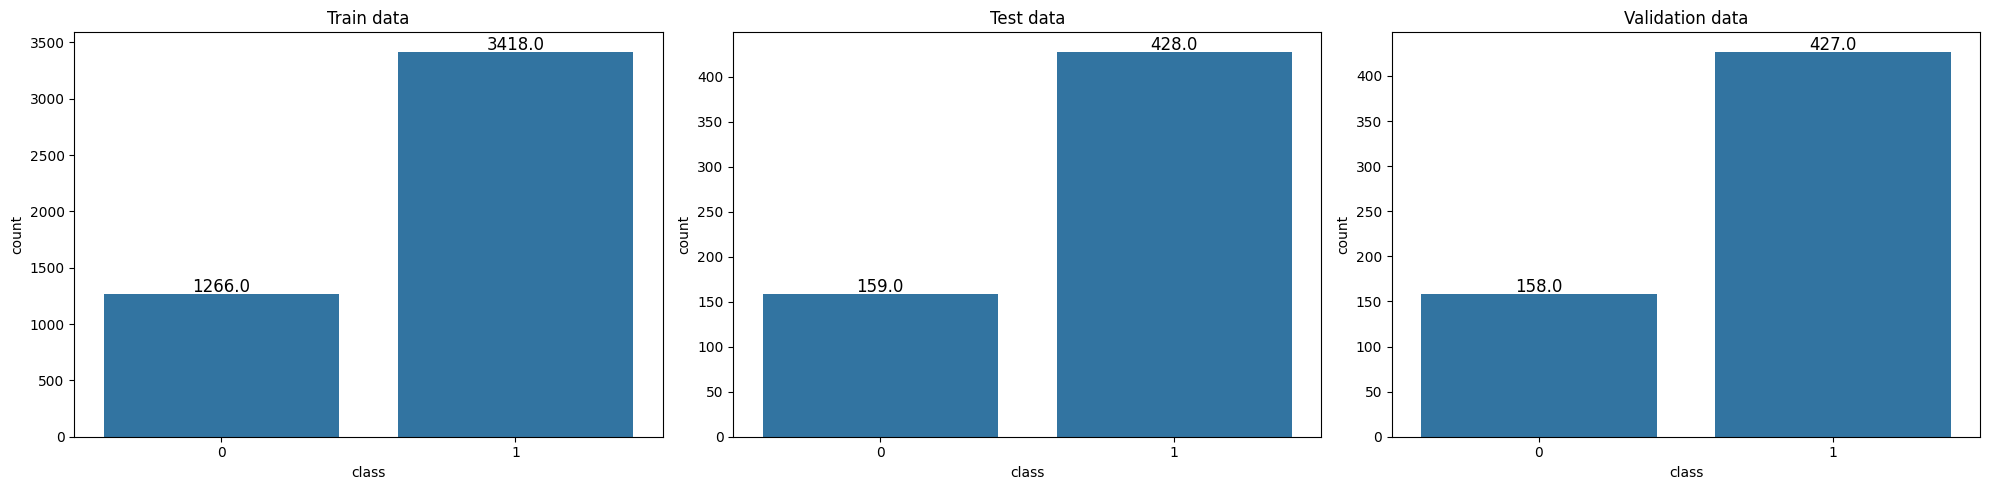

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Criação dos DataFrames para os conjuntos de dados
df_train = pd.DataFrame(train_class_counts.items(), columns=['class', 'count'])
df_test = pd.DataFrame(test_class_counts.items(), columns=['class', 'count'])
df_val = pd.DataFrame(validation_class_counts.items(), columns=['class', 'count'])

# Plotando as distribuições com seaborn
plt.figure(figsize=(20, 5))

# Função para adicionar os valores nas barras
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center',
                    fontsize = 12, color='black',
                    xytext = (0, 5),  # Desloca o valor para cima
                    textcoords='offset points')

# Plot para o conjunto de treinamento
plt.subplot(1, 3, 1)
ax_train = sns.barplot(x='class', y='count', data=df_train)
add_value_labels(ax_train)
plt.title('Train data')

# Plot para o conjunto de teste
plt.subplot(1, 3, 2)
ax_test = sns.barplot(x='class', y='count', data=df_test)
add_value_labels(ax_test)
plt.title('Test data')

# Plot para o conjunto de validação
plt.subplot(1, 3, 3)
ax_val = sns.barplot(x='class', y='count', data=df_val)
add_value_labels(ax_val)
plt.title('Validation data')

plt.tight_layout()
plt.show()


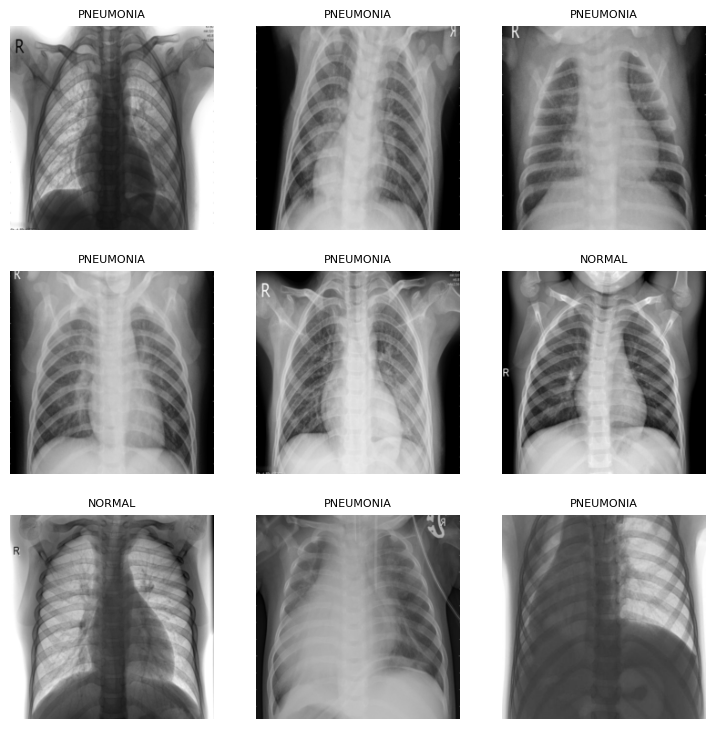

In [99]:
# Definindo a seed para garantir a reprodutibilidade dos resultados
torch.manual_seed(42)

# Configurando o tamanho da figura para exibir as imagens
fig = plt.figure(figsize=(9, 9))

# Definindo a grade de visualização com 3 linhas e 3 colunas
rows, cols = 3, 3

# Loop para exibir 9 imagens aleatórias do conjunto de dados de treinamento
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()  # Seleciona um índice aleatório
    img, label = train_data[random_idx]  # Obtém a imagem e o rótulo correspondentes

    # Adiciona um subplot para a imagem atual na grade de 3x3
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))  # permuta para colocar os canais de cor no final
    plt.title(class_names[label], fontsize=8)  # Define o título do subplot com o nome da classe
    plt.axis(False)  # Remove os eixos para uma visualização mais limpa


Ao final dessa seção temos conhecimento que nossa base de dados possui 5857 imagens divididas em 4684 na base de treino, 587 na base de teste e 586 na validação. Sendo 1583 radiografias sem consideradas normais e 4273 com o diagnóstico de pneumonia.

## Preparando os dados

In [117]:
# Definindo o tamanho do batch
batch_size = 32

# Tornando os datasets iteráveis em batches com o DataLoader, facilitando o treinamento em mini-batches

# DataLoader para o conjunto de dados de treinamento
train_dataloader = DataLoader(
    dataset = train_data,  # Conjunto de dados de treinamento
    batch_size = batch_size,  # Quantidade de amostras por batch
    shuffle = True,  # Embaralha os dados em cada época para melhorar a generalização
    num_workers = os.cpu_count()  # Número de subprocessos para carregar os dados (utiliza todos os núcleos da CPU disponíveis)
)

# DataLoader para o conjunto de dados de teste
test_dataloader = DataLoader(
    dataset = test_data,  # Conjunto de dados de teste
    batch_size = batch_size,  # Quantidade de amostras por batch
    shuffle = False,  # Não embaralha os dados (mantém a ordem para avaliação consistente)
    num_workers = os.cpu_count()  # Utiliza todos os núcleos da CPU para otimizar o carregamento de dados
)

# DataLoader para o conjunto de dados de validação
validation_dataloader = DataLoader(
    dataset = validation_data,  # Conjunto de dados de validação
    batch_size = batch_size,  # Quantidade de amostras por batch
    shuffle = False,  # Não embaralha os dados (mantém a ordem para avaliação consistente)
    num_workers = os.cpu_count()  # Utiliza todos os núcleos da CPU para otimizar o carregamento de dados
)

In [118]:
# Verificando o tamanho dos batches
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")
print(f"Length of validation dataloader: {len(validation_dataloader)} batches of {batch_size}")

Length of train dataloader: 147 batches of 32
Length of test dataloader: 19 batches of 32
Length of validation dataloader: 19 batches of 32


## Construindo o modelo

In [119]:
# Definindo o device que iremos utilizar (sempre obta pela GPU quando disponível)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [120]:
class ChestScanModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    # Primeiro block convolucional

    # Imagem entra aqui com 3 x 224 x 224
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),


      nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2))  # imagem sai daqui com 3 x 112 x 112

    # Segundo bloco convolucional
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))  # imagem sai daqui com 3 x 56 x 56

    # Terceiro bloco convolucional
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))  # imagem sai daqui com 3 x 28 x 28

    # Quarto bloco convolucional
    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))  # imagem sai daqui com 3 x 14 x 14

    # Quinto bloco convolucional
    self.conv_block_5 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))  # imagem sai daqui com 3 x 7 x 7

    # Camada de classificação
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7, out_features = hidden_units * 7 * 7),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = hidden_units * 7 * 7, out_features = hidden_units * 7 * 7),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = hidden_units * 7 * 7, out_features = output_shape),  # camada de output (outputs são logits)
        )

  def forward(self, x:torch.Tensor)->torch.Tensor:
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.conv_block_4(x)
    x = self.conv_block_5(x)
    x = self.classifier(x)
    return x

model = ChestScanModel(input_shape = 3, hidden_units = 64, output_shape = len(class_names)).to(device)
model

ChestScanModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(

Aqui optei por um modelo com arquitetura parecida com o VGG-19, com a diferença de ter colocado camadas de normalização `torch.nn.BatchNorm2d()` antes das funções de ativação e algumas camadas de dropout no bloco de classificação para ajudar na regularização.

## Definido a loss e otimizador

In [121]:
accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 1e-4, weight_decay = 1e-5)

## Criando algumas funções úteis (treino, teste e medição de tempo)

In [122]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Função para treinar o modelo
def train_step(modelo: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy: torchmetrics.Accuracy,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  modelo.to(device)
  modelo.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = modelo(X)  # dada nosso modelo aqui estão contidas as pred probs

    # 2. Calculando a loss/acc
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    acc = accuracy(y_pred.argmax(dim = 1), y)
    train_acc += acc.item()

    # 3. Zerando o gradiente
    optimizer.zero_grad()

    # 4. Peformando o backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Calculando a perda e acurácia por época
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  # Print do que está acontecendo
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc * 100:.2f}%")

In [123]:
# Função para testar o modelo
def test_step(modelo: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy: torchmetrics.Accuracy,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  modelo.to(device)
  modelo.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = modelo(X)  # dada nosso modelo aqui estão contidas as pred probs

      # 2. Calculando a loss/acc
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      acc = accuracy(y_pred.argmax(dim = 1), y)
      test_acc += acc.item()

    # Calculando a perda e acurácia por época
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    # Print do que está acontecendo
    print(f"Val loss: {test_loss:.5f} | Val acc: {test_acc * 100:.2f}%")

In [124]:
# Criando função para medir o tempo de treinamento
def print_train_time(time_start: float,
                     time_end: float,
                     device: torch.device = device):
  return print(f"Train time on {device}: {time_end - time_start} seconds")

## Realizando o treinamento

In [125]:
# Escolhendo a seed e iniciando a marcação de tempo
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start_on_cpu = timer()

# Número de épocas
epochs = 5

# Loop de treino e teste
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model, train_dataloader, loss_fn, optimizer, accuracy.to(device))
    test_step(model, validation_dataloader, loss_fn, accuracy.to(device))

# Maracação final do tempo
train_time_end_on_cpu = timer()
print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.28312 | Train acc: 87.82%
Val loss: 0.33386 | Val acc: 86.84%
Epoch: 1
-------
Train loss: 0.18217 | Train acc: 92.69%
Val loss: 0.18230 | Val acc: 92.43%
Epoch: 2
-------
Train loss: 0.16756 | Train acc: 93.86%
Val loss: 0.16891 | Val acc: 94.41%
Epoch: 3
-------
Train loss: 0.16417 | Train acc: 93.85%
Val loss: 0.13597 | Val acc: 94.24%
Epoch: 4
-------
Train loss: 0.12869 | Train acc: 95.34%
Val loss: 0.16847 | Val acc: 93.91%
Train time on cuda: 440.83441188600045 seconds


## Avaliando o modelo na base de teste:

In [126]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    # Inicializa as variáveis para acumular a perda (loss) e a acurácia
    loss, acc = 0, 0

    # Coloca o modelo em modo de avaliação (desabilita dropout, batch norm, etc.)
    model.eval()

    # Desabilita o cálculo de gradientes durante a inferência
    with torch.inference_mode():
        # Itera sobre os dados no DataLoader
        for X, y in data_loader:
            # Move os dados para o mesmo dispositivo do modelo (GPU ou CPU)
            X, y = X.to(device), y.to(device)

            # Faz as previsões com o modelo
            y_pred = model(X)

            # Acumula o valor da perda e da acurácia por batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        # Escala a perda e a acurácia para encontrar a média por batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    # Retorna os resultados do modelo em um dicionário
    return {"model_name": model.__class__.__name__,  # Obtém o nome da classe do modelo
            "model_loss": loss.item(),  # Converte o tensor de perda para valor numérico
            "model_acc": acc.item() * 100}  # Converte o tensor de acurácia e multiplica por 100 para obter a porcentagem

# Avaliação do modelo usando a função eval_model
model_results = eval_model(model = model, data_loader = test_dataloader,
    loss_fn = loss_fn, accuracy_fn = accuracy)

# Exibe os resultados do modelo
model_results

{'model_name': 'ChestScanModel',
 'model_loss': 0.1796310395002365,
 'model_acc': 93.10705065727234}

In [127]:
def make_predictions(model: torch.nn.Module,
                     dataset: list,
                     device: torch.device = device):
    # Lista para armazenar as probabilidades previstas
    pred_probs = []

    # Coloca o modelo em modo de avaliação (desativa dropout, batch norm, etc.)
    model.eval()

    # Desabilita o cálculo de gradientes durante a inferência
    with torch.inference_mode():
        # Itera sobre o dataset (uma lista de amostras)
        for sample in dataset:
            # Adiciona uma dimensão extra à amostra (para que tenha o formato de batch) e move para o dispositivo
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Realiza a passagem direta (forward pass) pelo modelo
            pred_logit = model(sample)

            # Converte os logits para probabilidades usando softmax
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Coloca a probabilidade de previsão de volta na CPU para uso posterior
            pred_probs.append(pred_prob.cpu())

    # Empilha as probabilidades previstas para transformar a lista em um tensor
    return torch.stack(pred_probs)

In [128]:
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

# Fazendo predições utilizando a função make_predictions
pred_probs= make_predictions(model = model,
                             dataset = test_samples)

# pred probs -> pred labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 0, 1, 1, 1, 0, 0, 0, 0])

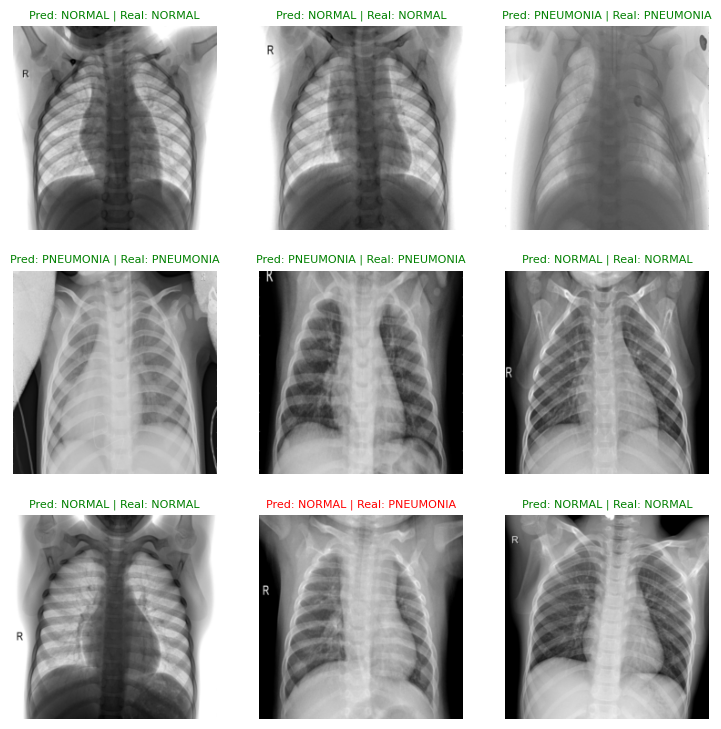

In [135]:
# Plotando as predições
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Criando subplots
  plt.subplot(nrows, ncols, i+1)

  # Permutando as dimensões (matplotlib aceita apenas [H, W, C])
  sample = sample.permute(1, 2, 0)

  # Plot da imagem
  plt.imshow(sample.squeeze())

  # Encontrando os pred labels
  pred_label = class_names[pred_classes[i]]

  # Pegando os labels reais
  truth_label = class_names[test_labels[i]]

  # Criando o título dos plots
  title_text = f"Pred: {pred_label} | Real: {truth_label}"

  # Checando os acertos/erros do modelo
  if pred_label == truth_label:
      plt.title(title_text, fontsize = 8 , c="g") # verde se certo
  else:
      plt.title(title_text, fontsize = 8, c="r") # vermelho se errado
  plt.axis(False);

## Avaliando outras métricas: A matriz de confusão

In [130]:
# Realizando previsões com o modelo treinado
y_preds = []  # Lista para armazenar as previsões

model.eval()  # Coloca o modelo em modo de avaliação (desabilita dropout e batch norm)

# Modo de inferência para garantir que não seja calculado o gradiente
with torch.inference_mode():
    # Itera sobre os dados de teste
    for X, y in tqdm(test_dataloader, desc = " Making predictions..."):
        # Envia os dados e os alvos para o dispositivo de destino (GPU ou CPU)
        X, y = X.to(device), y.to(device)

        # Realiza a passagem direta (forward pass) pelo modelo
        y_logit = model(X)

        # Converte as previsões de logits para probabilidades (softmax) e, em seguida, para rótulos de previsão
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)  # Realiza softmax na dimensão dos logits, não na dimensão do batch (dim=1)

        # Coloca as previsões de volta na CPU para avaliação
        y_preds.append(y_pred.cpu())

# Concatena a lista de previsões em um tensor único
y_pred_tensor = torch.cat(y_preds)


 Making predictions...:   0%|          | 0/19 [00:00<?, ?it/s]

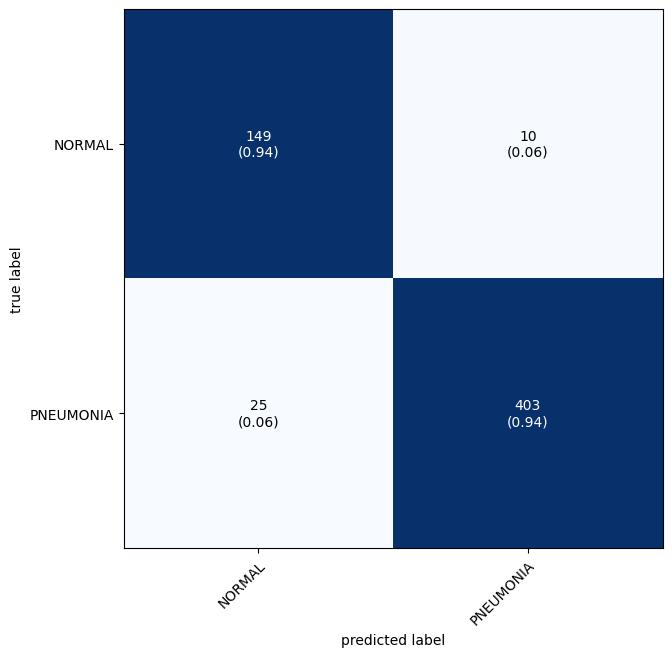

In [137]:
# Criação da instância da matriz de confusão para classificação binária
confmat = ConfusionMatrix(num_classes=len(class_names), task='binary')

# Converte os labels de test_data para um tensor PyTorch
target_tensor = torch.tensor(test_data.targets, device = y_pred_tensor.device)  # Garante que o tensor das labels esteja no mesmo dispositivo das previsões

# Calcula a matriz de confusão utilizando as previsões e os labels convertidos
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=target_tensor)  # Usa o tensor das labels convertido

# Plotando a matriz de confusão
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib trabalha melhor com arrays NumPy
    class_names=class_names,  # Transforma os rótulos das linhas e colunas em nomes de classes
    figsize=(10, 7),  # Define o tamanho da
    show_normed=True
);

Vemos que além da boa acurácia 93% o modelo também consegue distinguir bem entre as classes o que é excelente para nossos objetivos.

## Salvando o modelo

In [132]:
# Criando o diretorio
MODEL_PATH = Path('model')
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Criando o caminho que o modelo será salvo
MODEL_NAME = 'chest_scan_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Salvando o modelo
torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)

## Conclusão

Neste projeto, desenvolvemos um modelo de deep learning utilizando redes neurais convolucionais (CNNs) com a biblioteca PyTorch. O modelo alcançou uma acurácia de 93% na base de teste, após ser treinado por 5 épocas, com um tempo total de treinamento de 440 segundos. Além disso, a análise da matriz de confusão revelou que o modelo apresenta um bom desempenho na distinção entre radiografias normais e aquelas diagnosticadas com pneumonia, mostrando uma boa capacidade de classificação.